In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [2]:
data = pd.read_csv("data/amazon_alexa.tsv", delimiter = '\t', quoting=3)

print(f"Dataset Shape : {data.shape}")

Dataset Shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
print(f"Features Names : {data.columns.values}")  # Used for column names

Features Names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [6]:
data[data["verified_reviews"].isna()==True]  #  Check the column where value is not null

,rating,date,variation,verified_reviews,feedback


In [7]:
data.dropna(inplace=True) # For drop the null values

In [8]:
print(f"Dataset shape after remove null values : {data.shape}")

Dataset shape after remove null values : (3150, 5)


In [9]:
data['length'] = data["verified_reviews"].apply(len) # foe create new column and apply(len) used for written the length 

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
# Rondomly checking the 10th Record

print(f"'verified_reviews' column value : {data.iloc[10]['verified_reviews']}") # Original Value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") # Length of review using len
print(f"Length of column value : {data.iloc[10]['length']}") # Value of the column "Length"

'verified_reviews' column value : "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
Length of column value : 65


we can see that length of review is the same as length column of the record

In [12]:
data.dtypes  # for datatype of features

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

rating, feedback and length are integer values

date, variation and verified_reviews are string values

# Analyzing "Rating" Column

In [13]:
len(data)

3150

In [14]:
print(f"Rating Value count : \n{data['rating'].value_counts()}")

Rating Value count : 
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


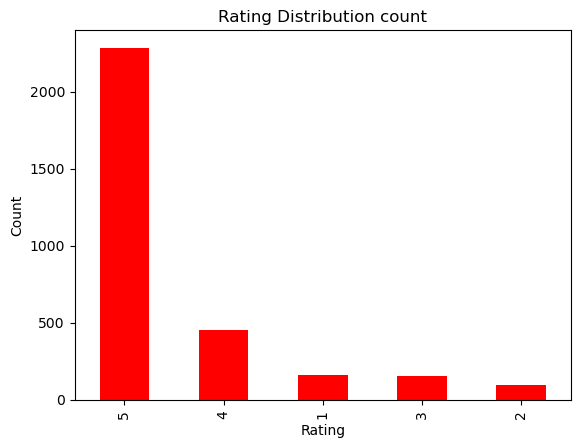

In [15]:
data["rating"].value_counts().plot.bar(color="red")
plt.title("Rating Distribution count")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [16]:
print(f"Rating Value count - percentage distribution : \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating Value count - percentage distribution : 
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64


<Axes: ylabel='Percentage wise distribution of rating'>

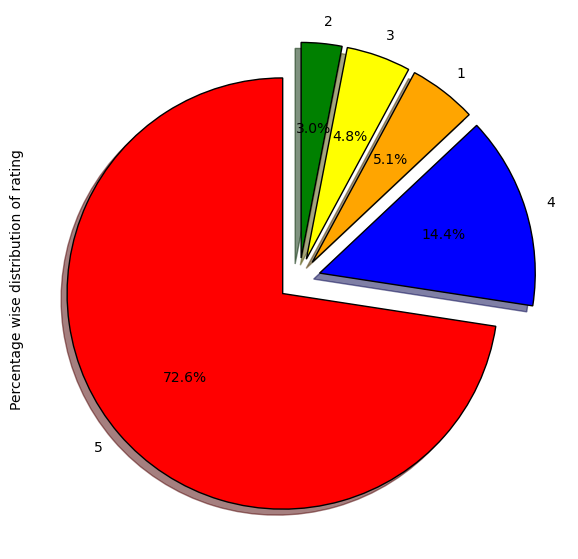

In [17]:
fig = plt.figure (figsize = (7,7))
colors = ("red", "blue", "orange", "yellow", "green")
wp = {"linewidth" : 1 , "edgecolor":"black"}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind="pie", autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode , label="Percentage wise distribution of rating")


# Analyzing "Feedback" Column

In [18]:
print(f"Feedback Value count : \n{data['feedback'].value_counts()}")

Feedback Value count : 
1    2893
0     257
Name: feedback, dtype: int64


In [19]:
review_0 = data[data['feedback'] == 0].iloc[1]["verified_reviews"]
print(review_0)

Sound is terrible if u want good music too get a bose


In [20]:
review_1 = data[data['feedback'] == 1].iloc[1]["verified_reviews"]
print(review_1)

Loved it!


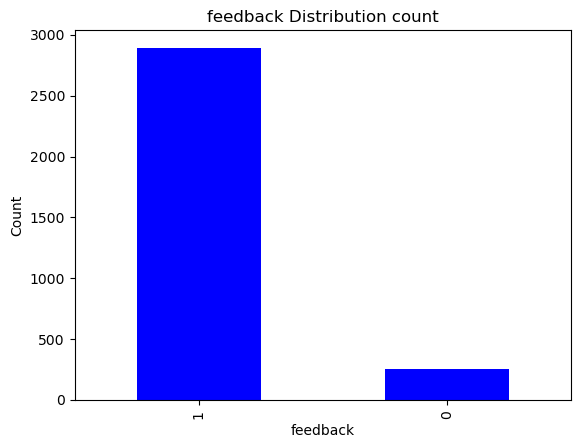

In [21]:
data["feedback"].value_counts().plot.bar(color="blue")
plt.title("feedback Distribution count")
plt.xlabel("feedback")
plt.ylabel("Count")
plt.show()

In [22]:
print(f"Feedack Value count - percentage distribution : \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedack Value count - percentage distribution : 
1    91.84
0     8.16
Name: feedback, dtype: float64


<Axes: ylabel='Percentage wise distribution of feedback'>

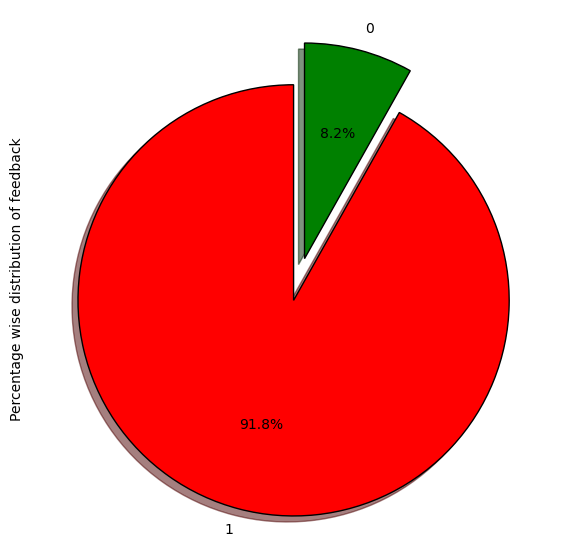

In [23]:
fig = plt.figure (figsize = (7,7))
colors = ("red", "green")
wp = {"linewidth" : 1 , "edgecolor":"black"}
tags = data['feedback'].value_counts()/data.shape[0]
explode = (0.1,0.1)
tags.plot(kind="pie", autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode , label="Percentage wise distribution of feedback")


In [24]:
# feedback = 0
data[data['feedback']==0]['rating'].value_counts()

1    161
2     96
Name: rating, dtype: int64

In [25]:
# feedback = 1
data[data['feedback']==1]['rating'].value_counts()

5    2286
4     455
3     152
Name: rating, dtype: int64

# Analyzing "variation" Column

In [26]:
print(f"Variation Value count : \n{data['variation'].value_counts()}")

Variation Value count : 
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


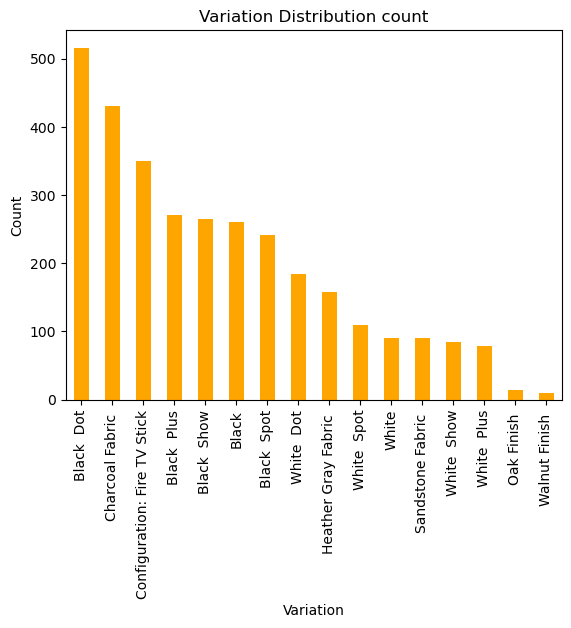

In [27]:
data["variation"].value_counts().plot.bar(color="orange")
plt.title("Variation Distribution count")
plt.xlabel("Variation")
plt.ylabel("Count")
plt.show()

In [28]:
print(f"Variation Value count - percentage distribution : \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation Value count - percentage distribution : 
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64


In [29]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

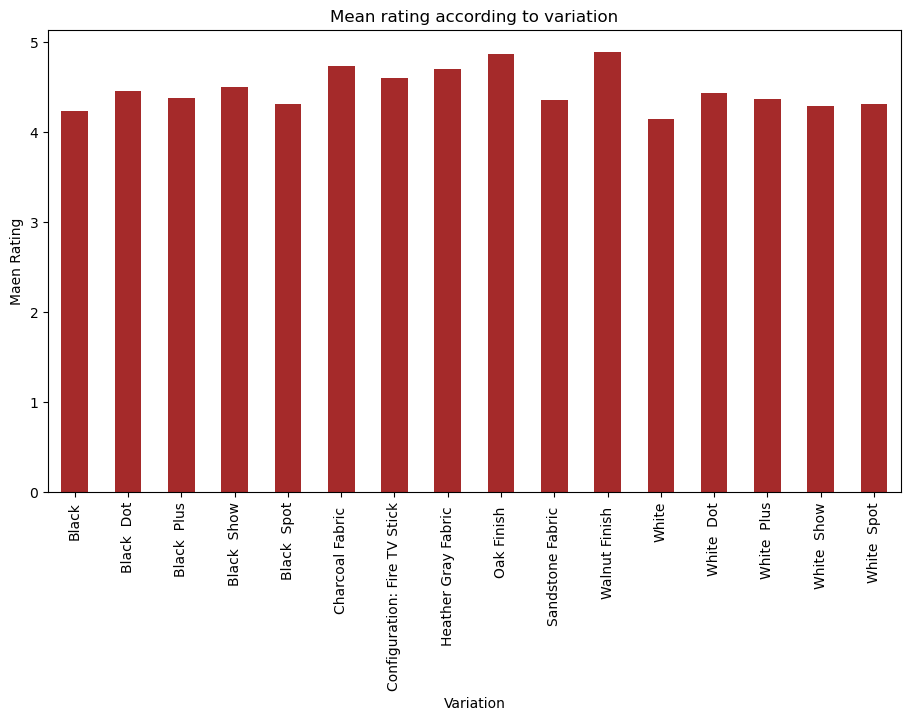

In [30]:
data.groupby('variation')['rating'].mean().plot.bar(color="brown", figsize = (11,6))
plt.title("Mean rating according to variation")
plt.xlabel("Variation")
plt.ylabel("Maen Rating")
plt.show()

# Analyzing "verified_reviews" Column

In [31]:
data.length.describe()

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distibution of length of review')]

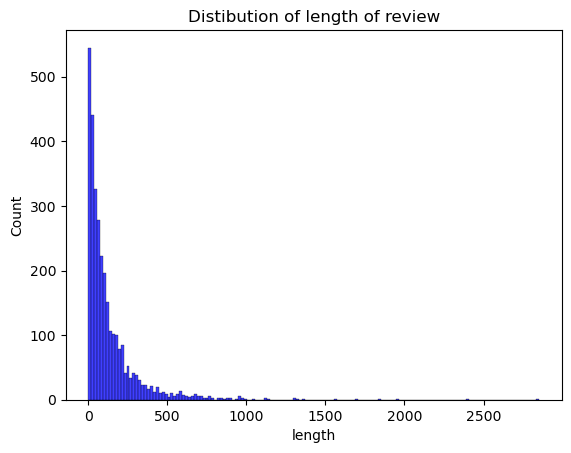

In [32]:
sns.histplot(data['length'],color='blue').set(title="Distibution of length of review")

[Text(0.5, 1.0, 'Distibution of length of review = 0')]

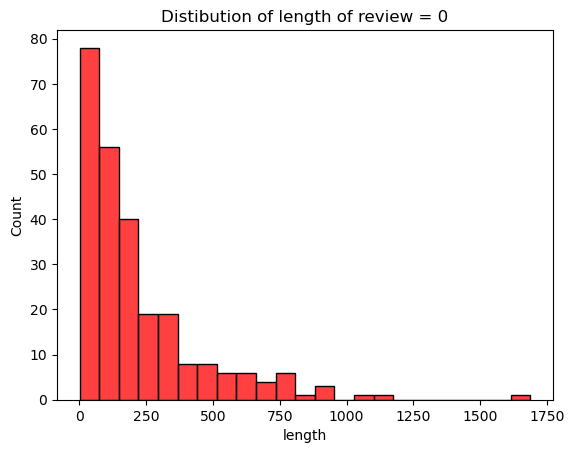

In [33]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title="Distibution of length of review = 0")

[Text(0.5, 1.0, 'Distibution of length of review = 1')]

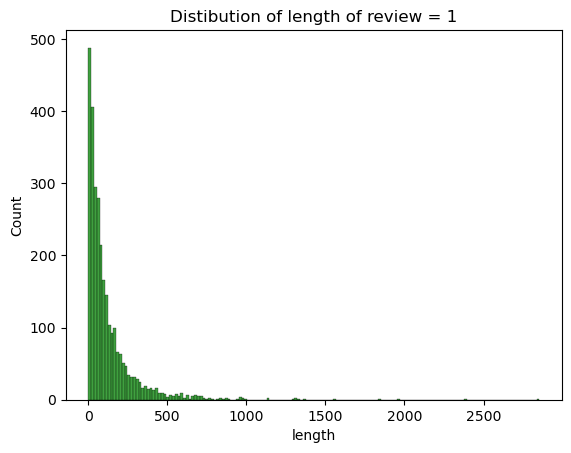

In [34]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title="Distibution of length of review = 1")

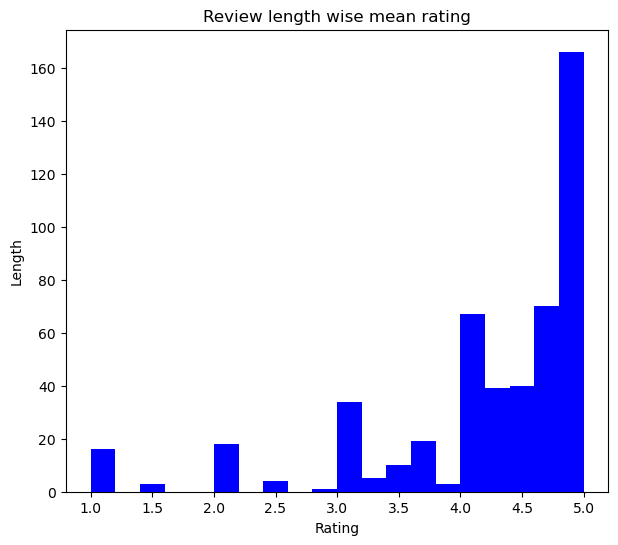

In [35]:
data.groupby('length')['rating'].mean().plot.hist(color="blue", figsize = (7,6), bins = 20)
plt.title("Review length wise mean rating")
plt.xlabel("Rating")
plt.ylabel("Length")
plt.show()

In [36]:
cv = CountVectorizer(stop_words="english")
words = cv.fit_transform(data.verified_reviews)

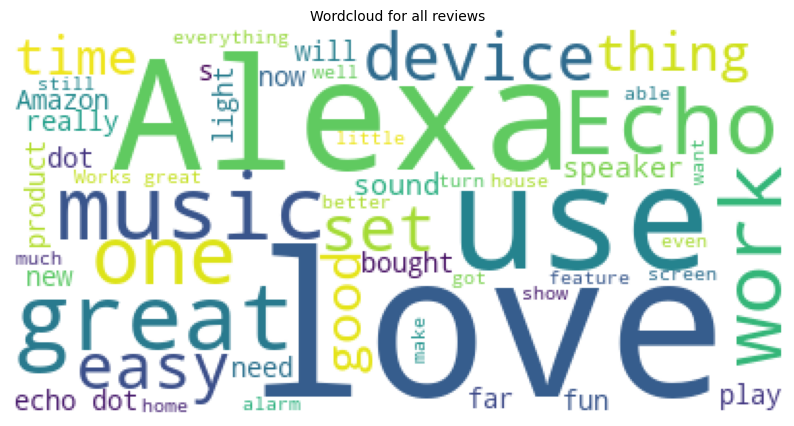

In [37]:
# combine all reviews
reviews = " ". join ([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color = "white", max_words=50)

# Geerate and Plot Wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [38]:
neg_reviews = " ". join ([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ". join ([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ". join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ". join(unique_positive)

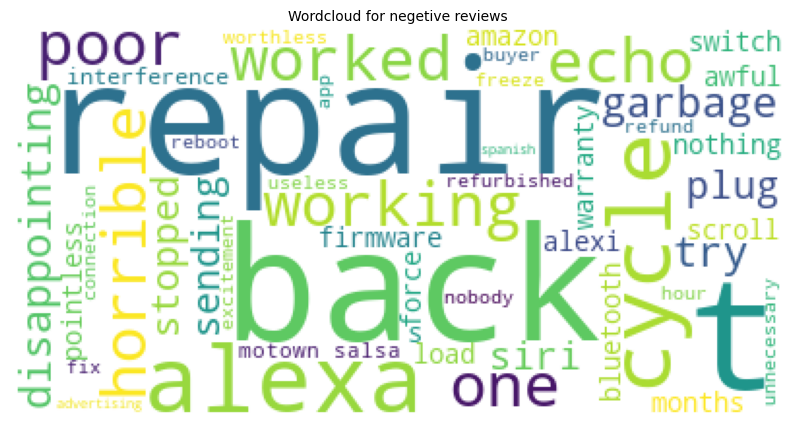

In [39]:
wc = WordCloud(background_color = "white", max_words=50)

# Geerate and Plot Wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negetive reviews', fontsize=10)
plt.axis('off')
plt.show()

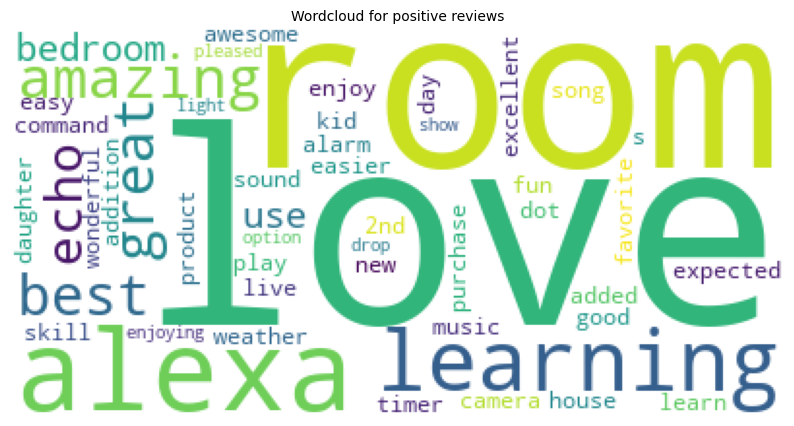

In [40]:
wc = WordCloud(background_color = "white", max_words=50)

# Geerate and Plot Wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

In [52]:
corpus = []
stemmer = PorterStemmer()
for i in range (0, data.shape[0]):
        review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
        review = review.lower()
        review = review.split()
    
        review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
        review = ' '.join(review)
        corpus.append(review)

In [53]:
cv = CountVectorizer(max_features=2500)  # Countverctorizer used for create bag of words
X = cv.fit_transform(corpus).toarray()
Y = data['feedback'].values

In [54]:
import os
import pickle

# Define the directory and file path
directory = 'Models'
file_path = os.path.join(directory, 'countvectorizer.pkl')

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the CountVectorizer object
pickle.dump(cv, open(file_path, 'wb'))


In [57]:
print(f"X Sahpe : {X.shape}")
print(f"Y Sahpe : {Y.shape}")
      

X Sahpe : (3150, 2500)
Y Sahpe : (3150,)


In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 15)

print(f"X Train : {X_train.shape}")
print(f"Y Train : {Y_train.shape}")
print(f"X Test : {X_test.shape}")
print(f"Y Test : {Y_train.shape}")

X Train : (2205, 2500)
Y Train : (2205,)
X Test : (945, 2500)
Y Test : (2205,)


In [64]:
print(f"X Train max value : {X_train.max()}")
print(f"X Test max value : {X_test.max()}")

X Train max value : 12
X Test max value : 10


In [68]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)  # well scale X_train and X_test so the all value are between 0 and 1.
X_test_scl = scaler.transform(X_test)

In [69]:
# Define the directory and file path
directory = 'Models'
file_path = os.path.join(directory, 'countvectorizer.pkl')

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the scaler object
pickle.dump(scaler, open(file_path, 'wb'))

In [71]:
model_rf = RandomForestClassifier() # Fitti=ed X_train and Y_train on Random Forest Classifier
model_rf.fit(X_train_scl, Y_train)

RandomForestClassifier()

In [72]:
print(f"Training Accuracy : ", model_rf.score(X_train_scl, Y_train))  # Check Accuracy of model
print(f"Testing Accuracy : ", model_rf.score(X_test_scl, Y_test))

Training Accuracy :  0.9941043083900227
Testing Accuracy :  0.9428571428571428


In [75]:
Y_preds = model_rf.predict(X_test_scl)  # predict on test set

In [76]:
cm = confusion_matrix(Y_test, Y_preds)  # Confusion Matrix

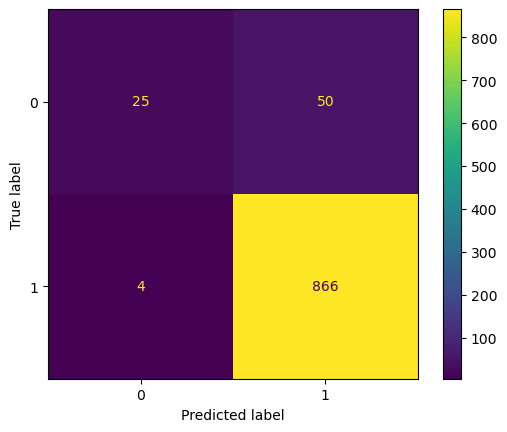

In [77]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [79]:
accuracies = cross_val_score (estimator = model_rf , X=X_train_scl, y=Y_train, cv = 10)

print(f"Accuracy : ",  accuracies.mean())
print(f"Standard Variance : ", accuracies.std())

Accuracy :  0.9369703825586179
Standard Variance :  0.011843148955755575


In [87]:
# Apply grid search to get the optimal parameter on Random Forest

params = {
    'bootstrap' : [True],
    'max_depth' : [80, 100],
    'min_samples_split' : [8,12],
    'n_estimators' : [100,300]
}

In [88]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Create a StratifiedKFold object
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator=model_rf, param_grid = params, cv=cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, Y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [93]:
print("Best Parameter Combination: {}".format(grid_search.best_params_))

Best Parameter Combination: {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [94]:
print("Cross Validation mean accuracy on train set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross Validation mean accuracy on test set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print(" accuracy score of test set: ", accuracy_score(Y_test, Y_preds))

Cross Validation mean accuracy on train set: 96.93902683326944
Cross Validation mean accuracy on test set: 92.22772758834591
 accuracy score of test set:  0.9428571428571428


In [96]:
model_xgb = XGBClassifier()    # Use XGboost
model_xgb.fit(X_train_scl, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [97]:
print(f"Training Accuracy : ", model_xgb.score(X_train_scl, Y_train))  # Check Accuracy of model
print(f"Testing Accuracy : ", model_xgb.score(X_test_scl, Y_test))

Training Accuracy :  0.9700680272108844
Testing Accuracy :  0.9407407407407408


In [98]:
Y_preds = model_xgb.predict(X_test_scl)  # predict on test set

In [100]:
cm = confusion_matrix(Y_test, Y_preds)  # Confusion Matrix
print(cm)

[[ 27  48]
 [  8 862]]


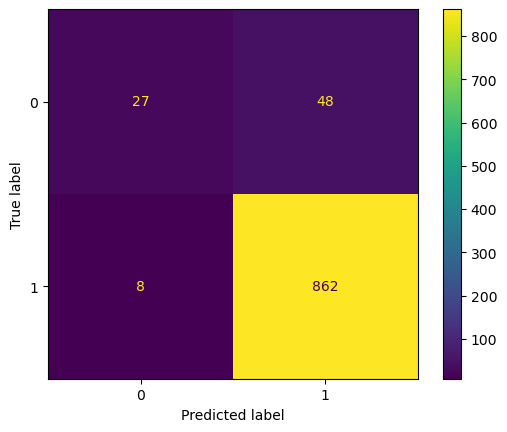

In [101]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [102]:
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

In [109]:
accuracies1 = cross_val_score (estimator = model_xgb , X=X_train_scl, y=Y_train, cv = 10)

print(f"Accuracy : ",  accuracies1.mean())
print(f"Standard Variance : ", accuracies1.std())

Accuracy :  0.9292616207322089
Standard Variance :  0.00856086045882552


In [103]:
model_dt = DecisionTreeClassifier()   # Use Decision Tree Classifier
model_dt.fit(X_train_scl, Y_train)

DecisionTreeClassifier()

In [104]:
print(f"Training Accuracy : ", model_dt.score(X_train_scl, Y_train))  # Check Accuracy of model
print(f"Testing Accuracy : ", model_dt.score(X_test_scl, Y_test))

Training Accuracy :  0.9941043083900227
Testing Accuracy :  0.9111111111111111


In [105]:
Y_preds = model_dt.predict(X_test_scl)  # predict on test set

In [106]:
cm = confusion_matrix(Y_test, Y_preds)  # Confusion Matrix
print(cm)



[[ 32  43]
 [ 41 829]]


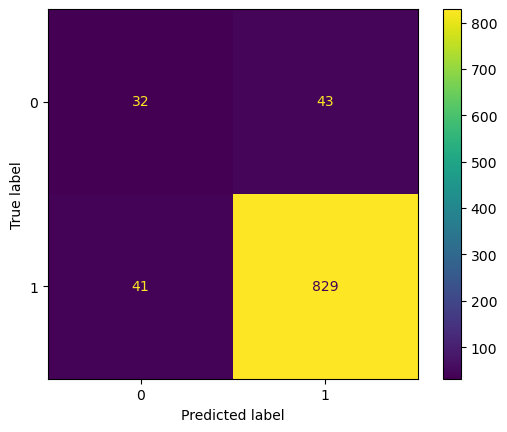

In [107]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [110]:
accuracies2 = cross_val_score (estimator = model_dt , X=X_train_scl, y=Y_train, cv = 10)

print(f"Accuracy : ",  accuracies2.mean())
print(f"Standard Variance : ", accuracies2.std())

Accuracy :  0.9174825174825175
Standard Variance :  0.02316727875398183
